In [191]:
### IMPORTS ###
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random

## Data Processing

In [199]:
### LOAD AND PREPARE DATA ###

#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


#Vectorize images
x_train = np.array([np.float64(x.flatten()) for x in x_train])
x_test = np.array([np.float64(x.flatten()) for x in x_test])


#Normalize images
x_train -= np.mean(x_train, axis = 0)
x_train /= np.std(x_train, axis = 0)
x_test -= np.mean(np.float64(x_test), axis = 0)
x_test /= np.std(x_test, axis = 0)

#One hot encoding of labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)


#Insert '1' for bias
x_train = np.insert(x_train, 0, [1] * len(x_train), axis=1)
x_test = np.insert(x_test, 0, [1] * len(x_test), axis=1)


print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

Train: X=(50000, 3073), y=(50000, 10)
Test: X=(10000, 3073), y=(10000, 10)


# MultiLayer Perceptron Implementation

In [188]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MultiLayerPerceptron:

  def __init__(self, activation_function, num_hidden_layers, hidden_layers_width):
    self.activation_function = activation_function
    self.num_hidden_layers = num_hidden_layers
    self.hidden_layers_width = hidden_layers_width
    self.loss_per_epoch = []


    #Initialize weights with given number of hidden layers (0, 1 or 2)
    if num_hidden_layers == 0:
      self.w1 = np.random.rand(10, 3073)/100

    elif num_hidden_layers == 1:
      if len(hidden_layers_width) != 1:
        raise Exception("Invalid input: len(hidden_layers_width) != num_hidden_layers")
      self.w1 = np.random.rand(hidden_layers_width[0], 3073)/100
      self.w2 = np.random.rand(10, hidden_layers_width[0])/100

    elif num_hidden_layers == 2:
      if len(hidden_layers_width) != 2:
        raise Exception("Invalid input: len(hidden_layers_width) != num_hidden_layers")
      self.w1 = np.random.rand(hidden_layers_width[0], 3073)/100
      self.w2 = np.random.rand(hidden_layers_width[1], hidden_layers_width[0])/100
      self.w3 = np.random.rand(10, hidden_layers_width[1])/100
    else:
      raise Exception("Unsupported number of hidden layers")


  def fit(self, x, y, learning_rate, epsilon, max_iters, batch_size):

    num_of_batches = int(len(x)/batch_size)
    x_batches = np.array_split(x, num_of_batches)
    y_batches = np.array_split(y, num_of_batches)

    #Gradient descent
    norms = np.array([np.inf])
    t = 0
    print("Epochs: ")
    
    #RELU WITH 0 HIDDEN LAYERS
    if self.activation_function == self.relu and self.num_hidden_layers == 0:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad = self.relu_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad #* (1/num_of_batches)
          t += 1
          norms = np.array([np.linalg.norm(g) for g in grad])
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return

    #RELU WITH 1 HIDDEN LAYERS
    elif self.activation_function == self.relu and self.num_hidden_layers == 1:
      while t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2 = self.relu_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 #* (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 #* (1/num_of_batches)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return

    
    #TAN_H WITH 0 HIDDEN LAYERS
    if self.activation_function == self.tanh and self.num_hidden_layers == 0:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad = self.tanh_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad * (1/num_of_batches)
          t += 1
          norms = np.array([np.linalg.norm(g) for g in grad])
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return

    if self.activation_function == self.tanh and self.num_hidden_layers == 1:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2 = self.tanh_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 # * (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 # * (1/num_of_batches)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")
      return



  def relu_gradient(self, x, y):

    y_hat = self.predict(x)
    self.loss_per_epoch.append(MultiLayerPerceptron.total_loss(y, y_hat))
    N, D = x.shape

    if self.num_hidden_layers == 0:
      dy = y_hat - y
      dw1 = np.matmul(np.transpose(dy), x)
      return dw1

    elif self.num_hidden_layers == 1:
      dy = y_hat - y
      dw2 = np.dot(np.transpose(dy), np.transpose(self.z1_for_gradient)) / N
      derivative_q1 = (self.q1_for_gradient > 0).astype(int)
      tmp_dw1 = np.matmul(y, self.w2)
      tmp_dw1 = tmp_dw1 * np.transpose(derivative_q1)
      dw1 = np.matmul(np.transpose(x), tmp_dw1)
      dw1 = np.transpose(dw1)
      dz = np.dot(dy, self.w2)
      dv = np.dot(x.T, dz * derivative_q1.T).T / N
      return dv, dw2

  def tanh_gradient(self, x, y):
    y_hat = self.predict(x)
    self.loss_per_epoch.append(MultiLayerPerceptron.total_loss(y, y_hat))
    N, D = x.shape

    if self.num_hidden_layers == 0:
      dy = y_hat - y
      dw1 = np.matmul(np.transpose(dy), x)
      return dw1

    if self.num_hidden_layers == 1:
      dy = y_hat - y
      dw = (np.dot(self.z1_for_gradient, dy) / N).T
      dz = np.dot(dy, self.w2)
      dv = (np.dot(x.T, dz * (1 - (self.z1_for_gradient.T)**2)) / N).T
      return dv, dw


  def predict(self, x):

    if self.num_hidden_layers == 0:
      return self.softmax(np.transpose(np.dot(self.w1, np.transpose(x))))

    elif self.num_hidden_layers == 1:
      q1 = np.dot(self.w1, np.transpose(x))
      z1 = self.activation_function(q1)
      self.q1_for_gradient = q1
      self.z1_for_gradient = z1
      return self.softmax(np.transpose(np.dot(self.w2, z1)))
    else:
      z1 = self.activation_function(np.matmul(self.w1, np.transpose(x)))
      z2 = self.activation_function(np.matmul(self.w2, z1))
      return self.softmax(np.transpose(np.matmul(self.w3, z2)))

  
  @staticmethod
  def relu(x):
    return (x + np.abs(x))/2

  @staticmethod
  def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

  @staticmethod
  def softmax(x):
    R, C = x.shape
    for i in range(R):
      denominator = sum([np.exp(j) for j in x[i]])
      denominator = denominator if denominator > 0 else 1
      for j in range(C):
        x[i][j] = np.exp(x[i][j])/denominator
    return x

  @staticmethod
  def accuracy(y, y_hat):

    accurate_classifications = 0

    for i, y in enumerate(y):
      category = np.argmax(y)
      predicted_category = np.argmax(y_hat[i])

      if category == predicted_category:
        accurate_classifications += 1

    return accurate_classifications/len(y_hat)

  @staticmethod
  def total_loss(y, y_hat):

    loss = 0

    for i, y in enumerate(y):
      category = np.argmax(y)
      predicted_value = y_hat[i][category]
      loss += (-1 * np.log(predicted_value))

    return loss



Epochs: 
1 2 3 4 5 6 7 8 9 10 
10 iterations performed
Accuracy:  62.2 %


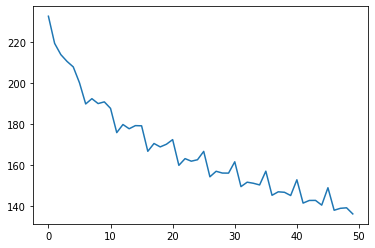

In [215]:
shuffle = list(zip(x_train, y_train))
random.shuffle(shuffle)
x_train, y_train = zip(*shuffle)
num_train = 500

mlp = MultiLayerPerceptron(MultiLayerPerceptron.tanh, 0, [300])
mlp.fit(x_train[:num_train], y_train[:num_train], learning_rate=0.0004, epsilon=0.0000001, max_iters=10, batch_size=100)
preds = mlp.predict(x_train[:num_train])
print("Accuracy: ", MultiLayerPerceptron.accuracy(y_train[:num_train], preds)*100, "%")
plt.plot(range(len(mlp.loss_per_epoch)), mlp.loss_per_epoch)
plt.show()